# Krypton Corrections

## Correct energy using Kr maps and obtain resolution

### Author: JJGC

In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Sat Aug 25 17:56:13 2018


### Input files

In [2]:
from krcal.core.kr_types import KrFileName

input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"

input_file_names  = ['dst_6284_trigger1_0000_7920.h5']
                    

output_file_name  = ' '
map_file_name     = 'kr_maps_6284.h5'
map_file_name_ts  = 'kr_maps_ts_6284.h5'
emap_file_name    = 'kr_emap_6284.h5'

krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_file_name)

### Notebook configuration

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [4]:
import os
import time
import datetime 
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings

In [5]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units
import invisible_cities.reco.corrections      as corrf

In [345]:
from krcal.core.io_functions       import kdst_write
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import read_maps_ts
from krcal.core.io_functions       import write_energy_map
from krcal.core.io_functions       import read_energy_map

In [7]:
from krcal.core.core_functions          import time_delta_from_time
from krcal.core.core_functions          import phirad_to_deg

In [8]:
from krcal.core.analysis_functions      import kr_ranges_and_bins
from krcal.core.analysis_functions      import fiducial_volumes
from krcal.core.analysis_functions      import fid_eff
from krcal.core.analysis_functions      import select_rphi_sectors
from krcal.core.analysis_functions      import plot_sector
from krcal.core.analysis_functions      import plot_sectors
from krcal.core.analysis_functions      import events_sector
from krcal.core.analysis_functions      import event_map
from krcal.core.analysis_functions      import kr_event_selection
from krcal.core.analysis_functions      import kr_event

In [12]:
from krcal.core.fit_lt_functions        import fit_lifetime
from krcal.core.fit_lt_functions        import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_functions        import print_fit_lifetime
from krcal.core.fit_lt_functions        import time_fcs
from krcal.core.fit_lt_functions        import fit_fcs_in_sectors
from krcal.core.fit_lt_functions        import fit_map

In [295]:
from krcal.core.fit_energy_functions    import fit_energy
from krcal.core.fit_energy_functions    import plot_fit_energy
from krcal.core.fit_energy_functions    import print_fit_energy
from krcal.core.fit_energy_functions    import plot_fit_energy_chi2
from krcal.core.fit_energy_functions    import resolution_r_z
from krcal.core.fit_energy_functions    import plot_resolution_r_z
from krcal.core.fit_energy_functions    import resolution_selected_r_z

In [14]:
from krcal.core.fit_lt_histograms          import histo_fit_sectors
from krcal.core.fit_lt_histograms          import print_fit_sectors_pars
from krcal.core.fit_lt_histograms          import plot_fit_sectors

In [15]:
from krcal.core.kr_types import PlotLabels, KrEvent
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core          import fit_functions_ic as fitf

In [371]:
from krcal.core.map_functions   import energy_map
from krcal.core.map_functions   import draw_wedges
from krcal.core.map_functions   import define_rphi_sectors
from krcal.core.map_functions   import rphi_sector_equal_area_map
from krcal.core.map_functions   import rphi_sector_map
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import draw_maps
from krcal.core.map_functions   import draw_map
from krcal.core.map_functions   import draw_maps_ts

In [17]:
from krcal.core.s1s2_functions  import energy_time_profile
from krcal.core.s1s2_functions  import energy_X_profile

In [392]:
from krcal.core.correction_functions import e0_correction
from krcal.core.correction_functions import lt_correction
from krcal.core.correction_functions import lt_correction_ts

In [19]:
import krcal.dev.corrections       as corrections 


In [20]:
from numpy import pi

In [21]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [22]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

### Input/output 

In [23]:
fn =filenames_from_list(krfn, input_path, output_path, map_path)
fn

KrFileName(input_file_names=['/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6284_trigger1_0000_7920.h5'], output_file_name='/Users/jjgomezcadenas/Projects/ICDATA/ldst/ ', map_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_6284.h5', map_file_name_ts='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_maps_ts_6284.h5', emap_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/kr_emap_6284.h5')

In [24]:
dst           = load_dsts(fn.input_file_names, "DST", "Events")

In [25]:
#unique_events = ~dst.event.duplicated()
#number_of_evts_full = np.count_nonzero(unique_events)

# Above does not work when glueing multiple DSTs, events ARE duplicated,
# since event number starts at 0, rather than taking true event number. 

print(f"Total number of events: {len(dst)}")

Total number of events: 1583342


In [24]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Select in R

In [406]:
RMAX       =180
NSECTORS   =100   # number of radial sectors, thus sector size RMAX/NSECTORS
SPHI       =10  # size of the wedge in degrees
NW = 360 / SPHI

fr = RMAX / NSECTORS
fphi = SPHI
print(f'fr = {fr}, fphi = {fphi}')


fr = 1.8, fphi = 10


In [142]:
dstf = dst[dst.R<RMAX]

In [143]:
dst = dstf

### Time differences in seconds

In [29]:
dst_time = dst.sort_values('event')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

### Ranges and binning

In [30]:
s1e_range = (2, 30)
s2e_range = (2000, 14000)
s2q_range = (200, 800)
xy_range  = (-220,  220)
z_range   = (10,  550)
krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 100,
                                                        ynbins    = 100,
                                                        znbins    = 50,
                                                        s2enbins  = 50,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

### Raw S2 energy vs Z

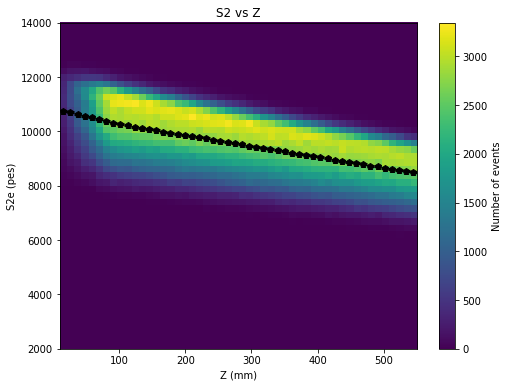

In [144]:
nevt = h2d(dst.Z, dst.S2e, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(8,6))

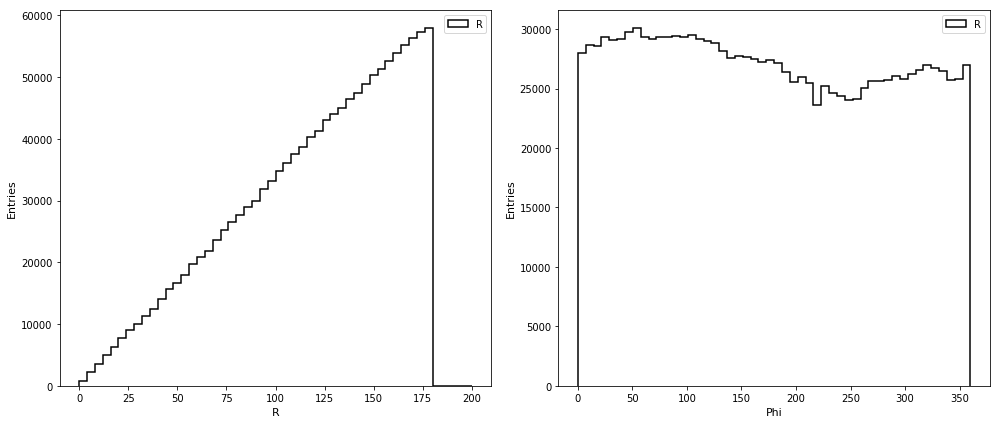

In [145]:
fig = plt.figure(figsize=(14,6))
ax      = fig.add_subplot(1, 2, 1)
(_)    = h1(dst.R, bins=50, range = (0,200), color='black', stats=False, lbl='R')
plot_histo(PlotLabels('R','Entries',''), ax)
ax      = fig.add_subplot(1, 2, 2)
(_)    = h1(phirad_to_deg(dst.Phi), bins=50, range = (0,360), color='black', stats=False, lbl='R')
plot_histo(PlotLabels('Phi','Entries',''), ax)
plt.tight_layout()

### Load maps

In [196]:
me0df, me0udf, mltdf, mltudf = read_maps(fn.map_file_name)
mu = (me0df.mean()).mean()
mx = (me0df.max()).max()

### Load TS maps

In [353]:
ts, tsMaps = read_maps_ts(fn.map_file_name_ts)

In [378]:
for i in ts.index:
    print(i)

0
1
2
3


In [380]:
ts.values

array([    0, 20000, 40000, 60000])

In [381]:
DT

array([0.00000000e+00, 2.80001163e-02, 1.34999990e-01, ...,
       8.68800290e+04, 8.68801010e+04, 8.68804980e+04])

In [385]:
for i in range(len(ts)-1):
    print(ts[i])

0
20000
40000


In [361]:
RMIN       = 18
RMAX       =180
NSECTORS   =10   # number of radial sectors, thus sector size RMAX/NSECTORS
SPHI       =10  # size of the wedge in degrees

R, PHI = rphi_sector_map(nSectors=NSECTORS, rmax=RMAX, sphi=SPHI)
NSECTORS = len(R.keys())

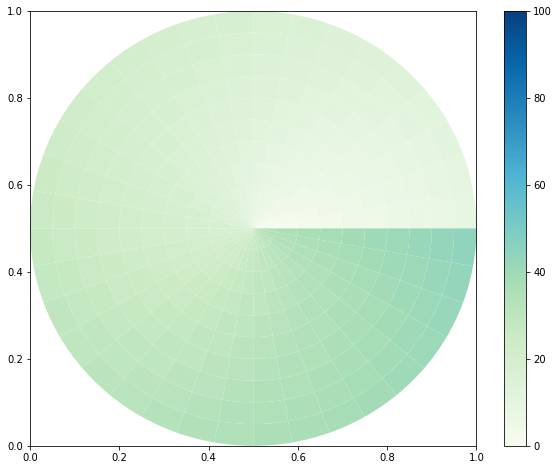

In [362]:
W = define_rphi_sectors(R, PHI, verbose=False)
draw_wedges(W, cmap = matplotlib.cm.GnBu, rmax = 180, 
            scale= 0.5, figsize=(10,8), alpha=1.0,
            cr =range(NSECTORS))

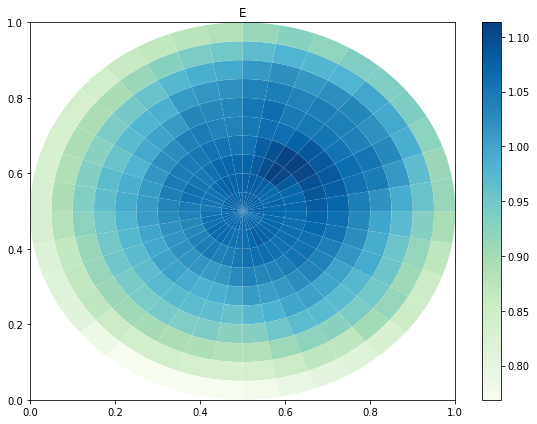

In [372]:
draw_map(W, aMap = me0df / mu,  
          cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
          alpha   = 1.0,  
          figsize=(8,6))

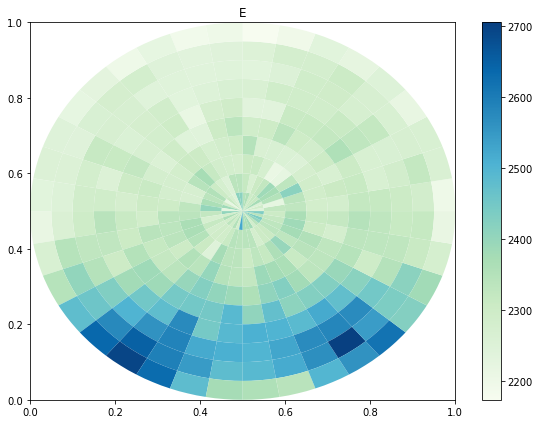

In [373]:
draw_map(W, aMap = mltdf,  
          cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
          alpha   = 1.0,  
          figsize=(8,6))

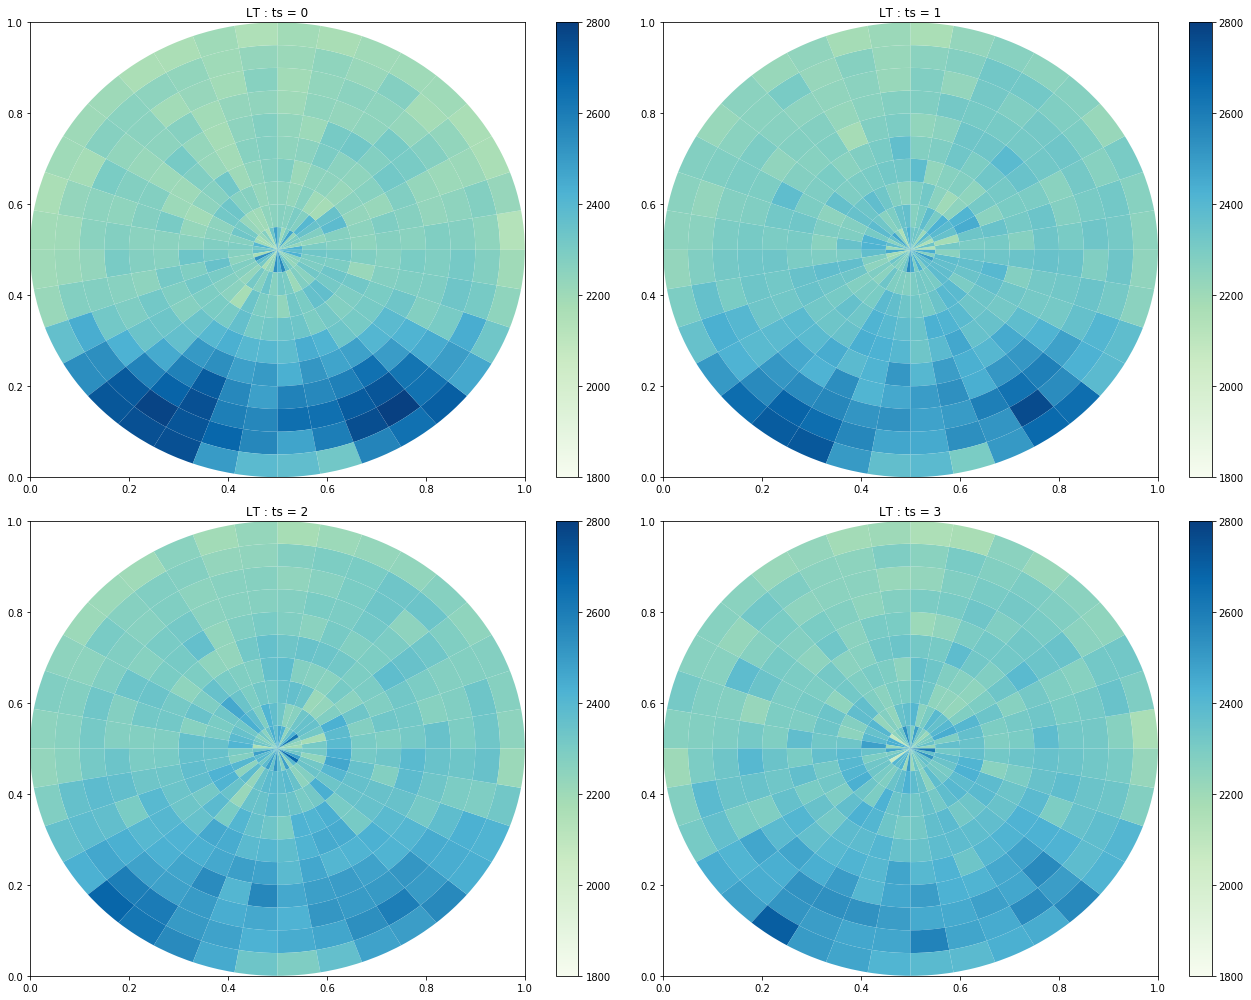

In [375]:
draw_maps_ts(W, tsMaps.values(),  
             wmap   = MapType.LT,
             ltlims = (1800, 2800),
             cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
             alpha   = 1.0,  
             figsize=(18,14))

In [409]:
fphi, fr = 360 / me0df.shape[0], RMAX / me0df.shape[1]
print(f'fphi ={fphi}, fr ={fr} ')

fphi =10.0, fr =18.0 


### E0 (geometry) correction

In [202]:
t0 = time.time()
E0 = e0_correction(dst.S2e.values, 
                  dst.R.values, 
                  dst.Phi.values, 
                  CE = me0df / mu,  # normalize to max E0
                  fr = fr, 
                  fphi = fphi)
t1 = time.time()
print(f' e0 correction: t = {t1 -t0}')

 e0 correction: t = 11.137817144393921


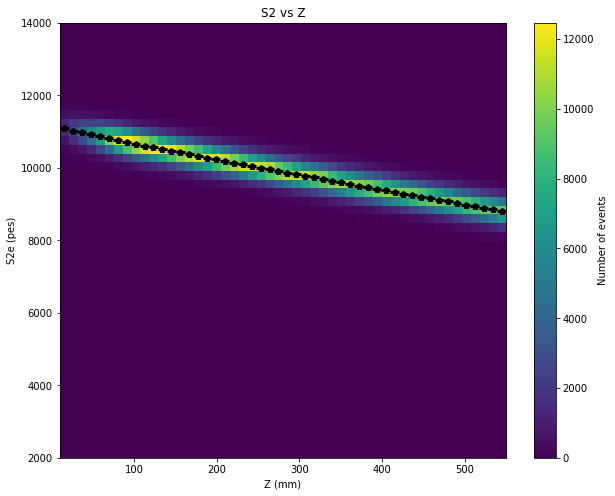

In [203]:
nevt = h2d(dst.Z, E0, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

In [417]:
t0 = time.time()
E = lt_correction(E0, 
                  dst.R.values, 
                  dst.Phi.values,
                  dst.Z.values, 
                  CLT = mltdf,
                  fr = fr, 
                  fphi = fphi)
t1 = time.time()
print(f' LT correction: t = {t1 -t0}')

 LT correction: t = 11.312823057174683


In [426]:
kge = kr_event(dst, DT, E0, dst.S2q)

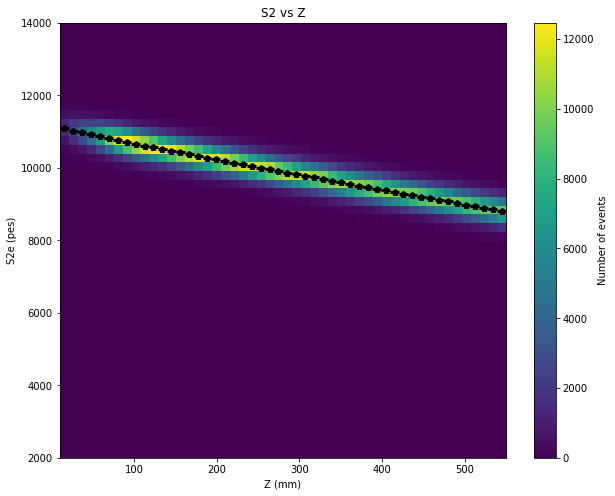

In [427]:
nevt = h2d(kge.Z, kge.E, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

In [434]:
t0 = time.time()
kre = lt_correction_ts(kge, ts, tsMaps, fr, fphi)
                  
t1 = time.time()
print(f' LT correction: t = {t1 -t0}')

(317376,)
(312561,)
(311677,)
(418783,)
 LT correction: t = 12.3468918800354


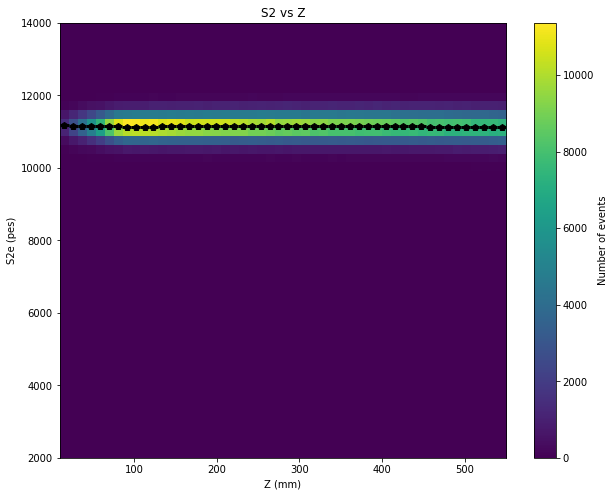

In [435]:
nevt = h2d(kre.Z, kre.E, krNbins.Z, krNbins.S2e, krRanges.Z, krRanges.S2e, 
           pltLabels=PlotLabels(x='Z (mm)', y='S2e (pes)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

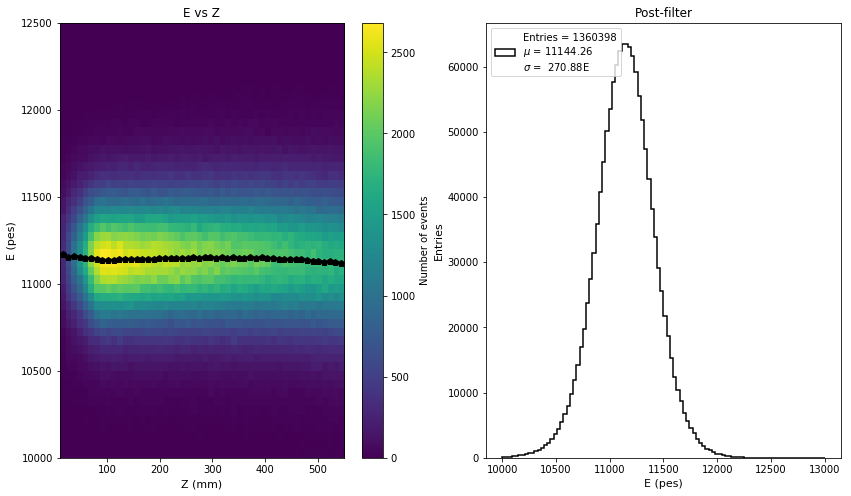

In [436]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst.Z, E, krNbins.Z, krNbins.S2e, krRanges.Z, (10000, 12500), profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(E,  bins = 100, range =(10000,13000), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')

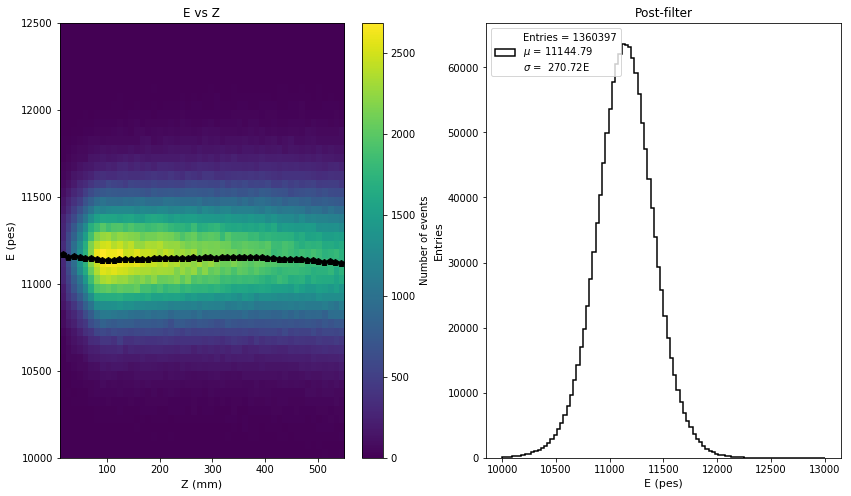

In [437]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(kre.Z, kre.E, krNbins.Z, krNbins.S2e, krRanges.Z, (10000, 12500), profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(kre.E,  bins = 100, range =(10000,13000), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')

In [438]:
fc = fit_energy(E, nbins=50, range=(10000, 12500))

  Fit was valid = True
 Emu       = 11146.103339640673 +-0.22998796790815876 
 E sigma   = 263.66610626368356 +-0.17933577032922607 
 chi2    = 10.716737110906921 
 sigma E/E (FWHM)     (%) =5.559031087716718
 sigma E/E (FWHM) Qbb (%) =0.7179597403561493 


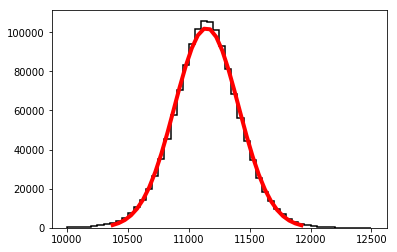

In [439]:
plot_fit_energy(fc)
print_fit_energy(fc)

In [208]:
kge = kr_event(dst, DT, E, E)

### Time dependence before/after correction

#### Before

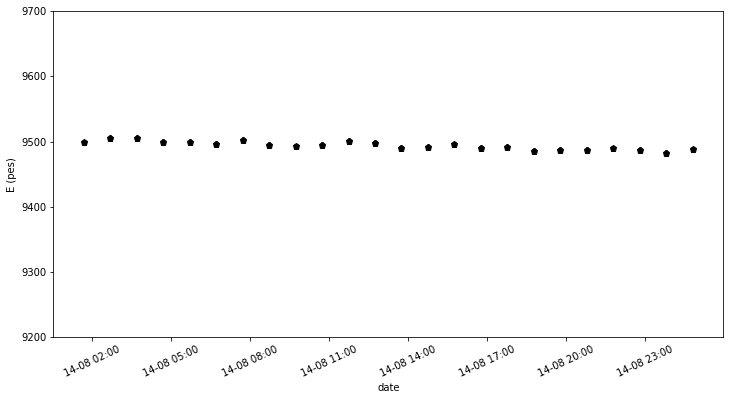

In [209]:
energy_time_profile(kge.T, kge.S2e, krNbins.T, krRanges.T, krTimes.timeStamps, 
                    erange=(9200, 9700),  
                    figsize=(12,6))

#### After

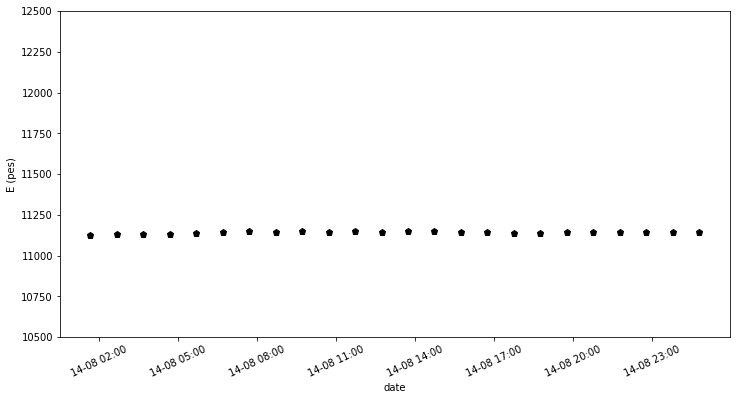

In [210]:
energy_time_profile(kge.T, kge.E, krNbins.T, krRanges.T, krTimes.timeStamps, 
                    erange=(10500, 12500),  
                    figsize=(12,6))

### Radial dependence

#### Before

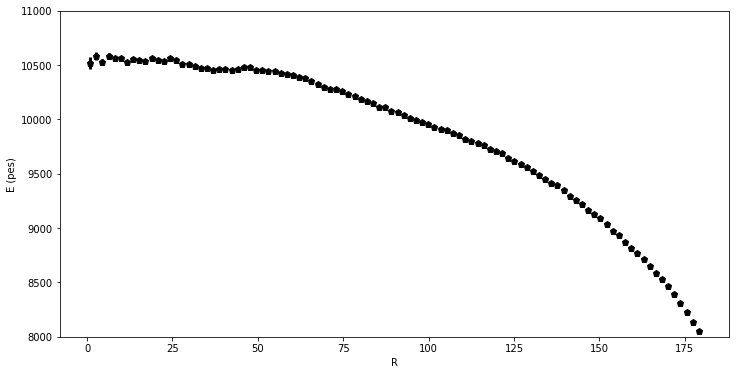

In [211]:
energy_X_profile(kge.R, kge.S2e, xnbins = 100, xrange=(0,180), xlabel = 'R',
                 erange=(8000, 11000),  
                 figsize=(12,6))

#### After: Further corrections needed!

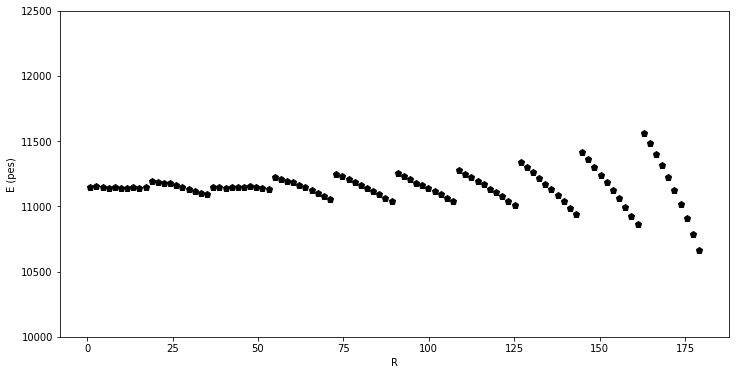

In [212]:
energy_X_profile(kge.R, kge.E, xnbins = 100, xrange=(0,180), xlabel = 'R',
                 erange=(10000, 12500),  
                 figsize=(12,6))

### Phi distribution

#### Before

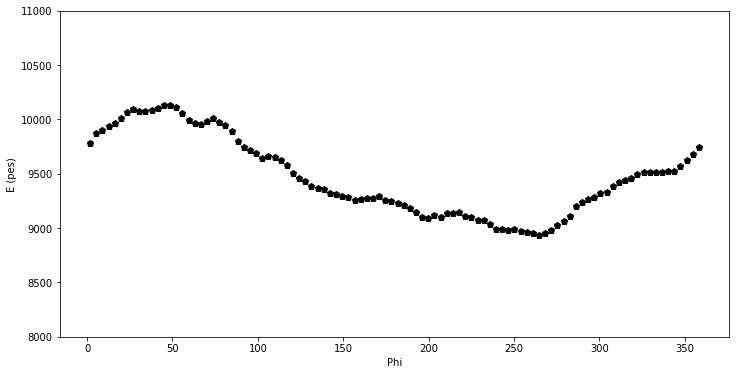

In [213]:
energy_X_profile(phirad_to_deg(kge.Phi), kge.S2e, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(8000, 11000),  
                 figsize=(12,6))

#### After! Further correction needed.

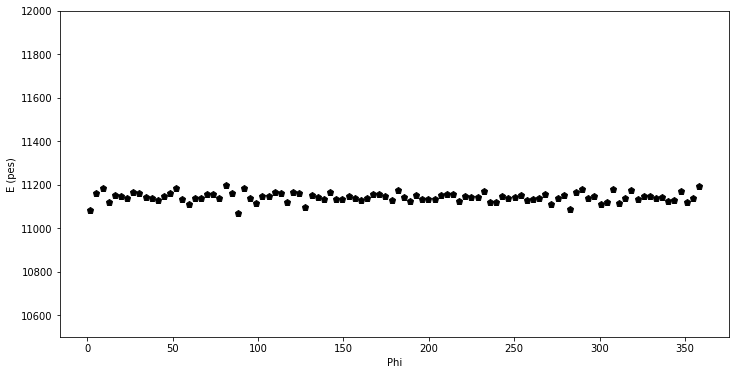

In [216]:
energy_X_profile(phirad_to_deg(kge.Phi), kge.E, xnbins = 100, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(10500, 12000),  
                 figsize=(12,6))

### Dependence with Z

#### Before: shows the effect of lifetime

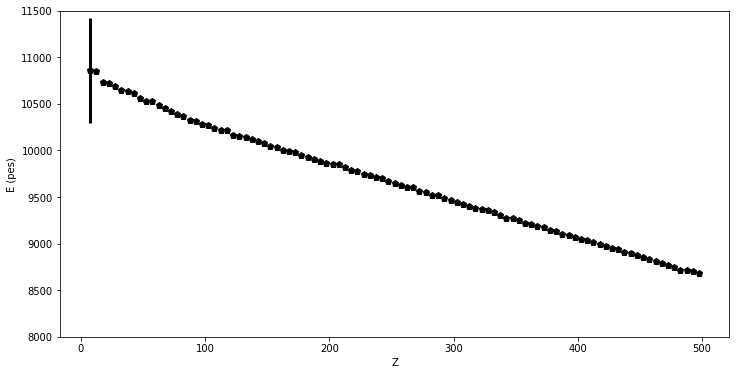

In [217]:
energy_X_profile(kge.Z, kge.S2e, xnbins = 100, xrange=(0,500), xlabel = 'Z',
                 erange=(8000, 11500),  
                 figsize=(12,6))

#### After: Lifetime corrected

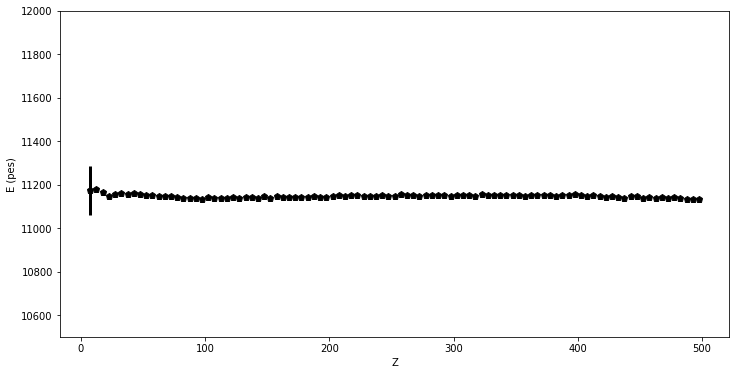

In [219]:
energy_X_profile(kge.Z, kge.E, xnbins = 100, xrange=(0,500), xlabel = 'Z',
                 erange=(10500, 12000),   
                 figsize=(12,6))

## Further geometrical correction is needed. This is done defining a fine-grained map for energy

In [240]:
#R, PHI =  rphi_sector_equal_area_map(rmin =  18, rmax = 180, sphi=3)
R, PHI = rphi_sector_map(nSectors=50, rmax=180, sphi=5)
#print(f'sectors on R   = {R}')
#print(f'sectors on PHI = {PHI}')

In [241]:
W = define_rphi_sectors(R, PHI, verbose=False)

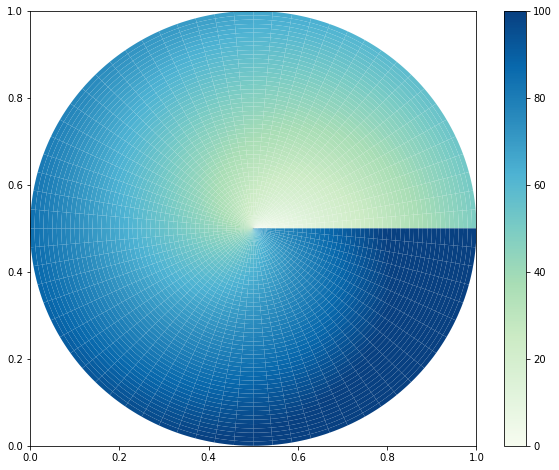

In [242]:
draw_wedges(W, cmap = matplotlib.cm.GnBu, rmax = 180, 
            scale= 0.5, figsize=(10,8), alpha=1.0,
            cr =range(50))

In [243]:
t0 = time.time()
KRES = select_rphi_sectors(dst, DT, E, E, W, verbose = True)
t1 = time.time()
print(f' KRES: t = {t1 -t0}')

 calling selection_mask
 sector = 0
 sector = 1
 sector = 2
 sector = 3
 sector = 4
 sector = 5
 sector = 6
 sector = 7
 sector = 8
 sector = 9
 sector = 10
 sector = 11
 sector = 12
 sector = 13
 sector = 14
 sector = 15
 sector = 16
 sector = 17
 sector = 18
 sector = 19
 sector = 20
 sector = 21
 sector = 22
 sector = 23
 sector = 24
 sector = 25
 sector = 26
 sector = 27
 sector = 28
 sector = 29
 sector = 30
 sector = 31
 sector = 32
 sector = 33
 sector = 34
 sector = 35
 sector = 36
 sector = 37
 sector = 38
 sector = 39
 sector = 40
 sector = 41
 sector = 42
 sector = 43
 sector = 44
 sector = 45
 sector = 46
 sector = 47
 sector = 48
 sector = 49
 selection_mask computed, filling RGES
 defining kr_event for sector 0
 defining kr_event for sector 1
 defining kr_event for sector 2
 defining kr_event for sector 3
 defining kr_event for sector 4
 defining kr_event for sector 5
 defining kr_event for sector 6
 defining kr_event for sector 7
 defining kr_event for sector 8
 defining

In [244]:
nMap = event_map(KRES)

In [245]:
nS = events_sector(nMap)

In [246]:
nS

array([  8.02777778,  24.58333333,  40.04166667,  56.75      ,
        70.16666667,  86.73611111, 103.13888889, 116.33333333,
       127.75      , 142.15277778, 155.08333333, 173.01388889,
       191.04166667, 202.58333333, 215.44444444, 233.93055556,
       249.69444444, 264.40277778, 278.04166667, 294.83333333,
       314.5       , 328.29166667, 342.77777778, 358.        ,
       370.61111111, 383.47222222, 404.63888889, 417.875     ,
       437.70833333, 451.72222222, 468.95833333, 479.29166667,
       501.52777778, 512.58333333, 527.97222222, 542.16666667,
       552.93055556, 568.25      , 585.13888889, 592.20833333,
       609.63888889, 627.18055556, 638.06944444, 650.5       ,
       666.59722222, 679.01388889, 697.80555556, 708.66666667,
       718.05555556, 724.51388889])

In [247]:
eM = energy_map(KRES)

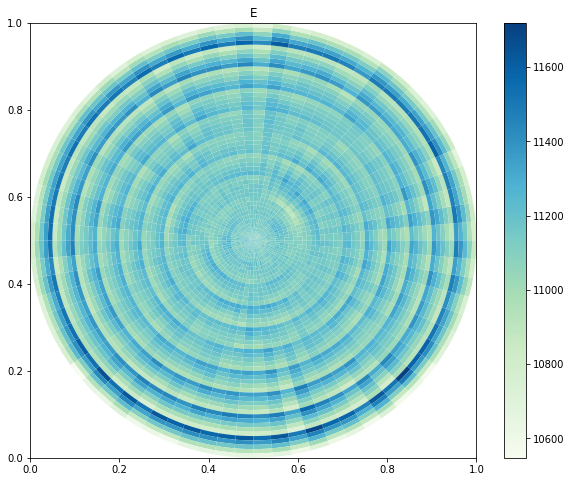

In [248]:
draw_energy_map(W, eM, 
                elims  = None,
                cmap    = matplotlib.cm.GnBu, rmax=180, scale=0.5,
                alpha   = 1.0,  
                figsize=(10,8))

In [249]:
write_energy_map(eM, filename=fn.emap_file_name)


In [250]:
eMap = read_energy_map(filename=fn.emap_file_name)

In [251]:
mu = (eMap.mean()).mean()
mu

11147.48511577105

In [252]:
ns = 50 # number of radial sectors used to compute map
nw = 72 # number of phi sectors used to compute map

fr = RMAX / ns
fphi = 5
print(f'fr = {fr}, fphi = {fphi}')

fr = 3.6, fphi = 5


In [253]:
t0 = time.time()
Ec = e0_correction(E, 
                  dst.R.values, 
                  dst.Phi.values, 
                  CE = eMap / mu,  # normalize to mean
                  fr = fr, 
                  fphi = fphi)
t1 = time.time()
print(f' e0 correction: t = {t1 -t0}')

 e0 correction: t = 10.884378910064697


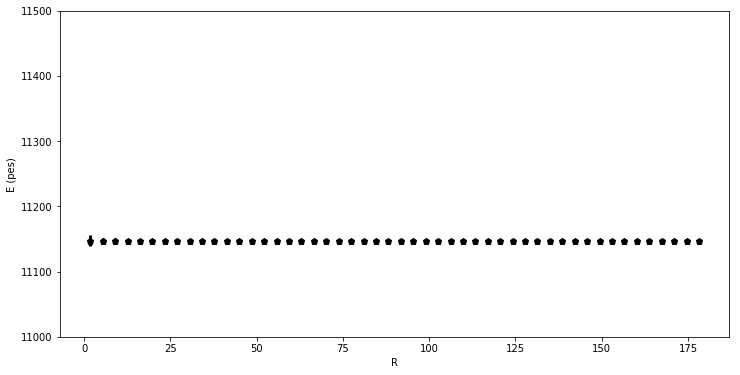

In [257]:
energy_X_profile(kge.R, Ec, xnbins = 50, xrange=(0,180), xlabel = 'R',
                 erange=(11000, 11500),  
                 figsize=(12,6))

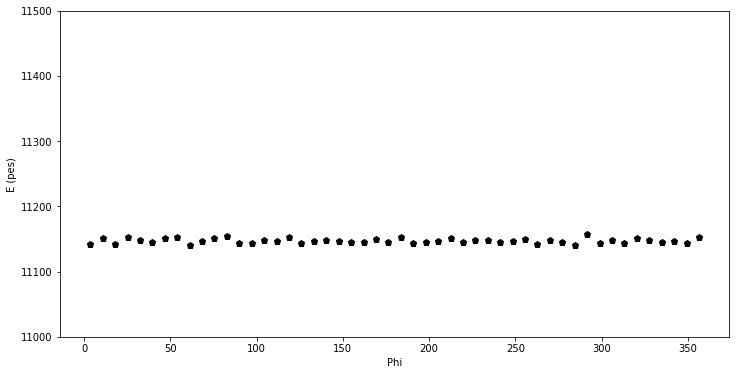

In [258]:
energy_X_profile(phirad_to_deg(kge.Phi), Ec, xnbins = 50, xrange=(0,360), 
                 xlabel = 'Phi',
                 erange=(11000, 11500),  
                 figsize=(12,6))

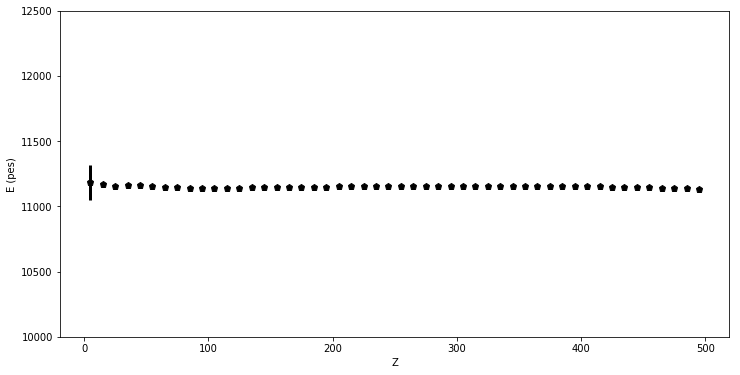

In [260]:
energy_X_profile(kge.Z, Ec, xnbins = 50, xrange=(0,500), xlabel = 'Z',
                 erange=(10000, 12500),   
                 figsize=(12,6))

### At large scales the profile appear to be flat

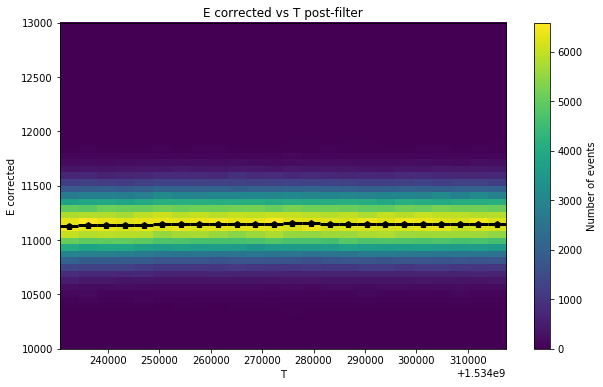

In [261]:
nevt = h2d(kge.T, Ec, krNbins.T, krNbins.S2e, krRanges.T, (10e+3,13e+3), 
           pltLabels=PlotLabels(x='T', y='E corrected', title='E corrected vs T post-filter'),
           profile=True,
           figsize=(10,6))

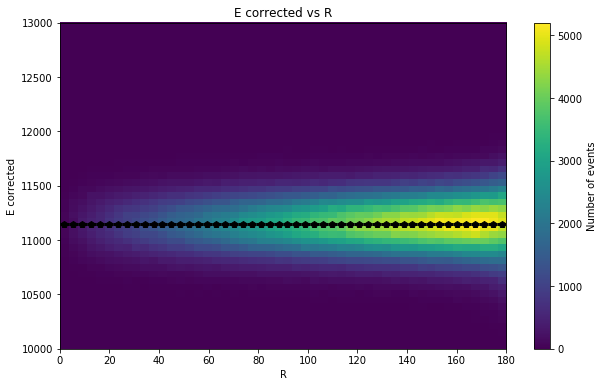

In [262]:
nevt = h2d(kge.R, Ec, 50, krNbins.S2e, (0,180), (10e+3,13e+3), 
           pltLabels=PlotLabels(x='R', y='E corrected', title='E corrected vs R'),
           profile=True,
           figsize=(10,6))

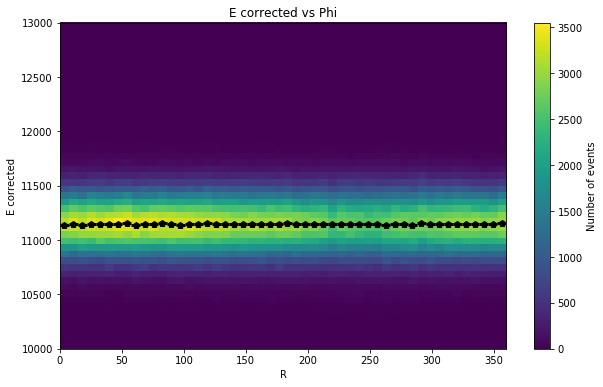

In [263]:
nevt = h2d(phirad_to_deg(kge.Phi), Ec, 50, krNbins.S2e, (0,360), (10e+3,13e+3), 
           pltLabels=PlotLabels(x='R', y='E corrected', title='E corrected vs Phi'),
           profile=True,
           figsize=(10,6))

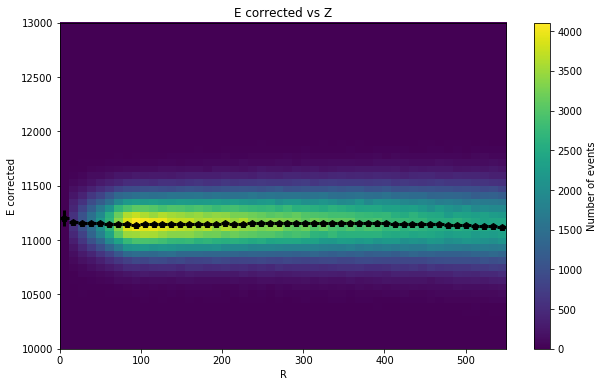

In [264]:
nevt = h2d(kge.Z, Ec, 50, krNbins.S2e, (0,550), (10e+3,13e+3),
           pltLabels=PlotLabels(x='R', y='E corrected', title='E corrected vs Z'),
           profile=True,
           figsize=(10,6))

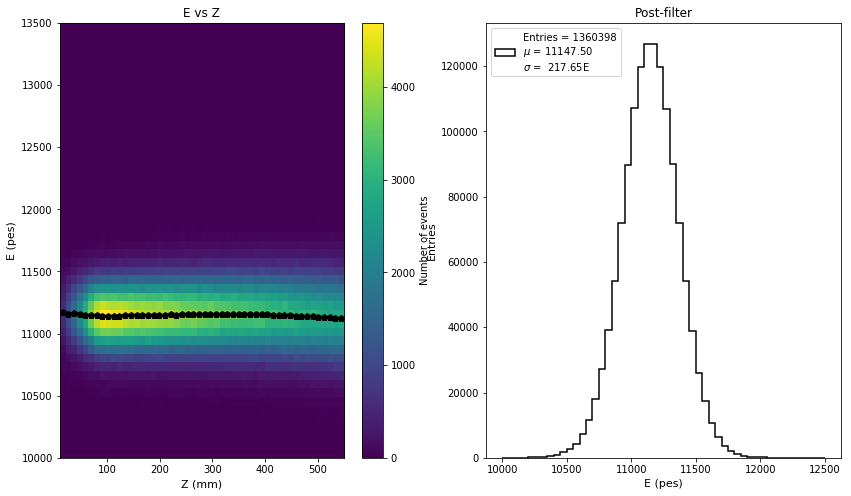

In [266]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

nevt = h2(dst.Z, Ec, krNbins.Z, krNbins.S2e, krRanges.Z, (10000, 13500), profile=True)
plot_histo(PlotLabels(x='Z (mm)', y='E (pes)', title='E vs Z'), ax, legend=False)

ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(Ec,  bins = 50, range =(10000,12500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 11148.514756028304 +-0.18718203769003627 
 E sigma   = 215.02008575584262 +-0.14247339292648037 
 chi2    = 5.037416062647941 
 sigma E/E (FWHM)     (%) =4.532417210579573
 sigma E/E (FWHM) Qbb (%) =0.5853705497139103 


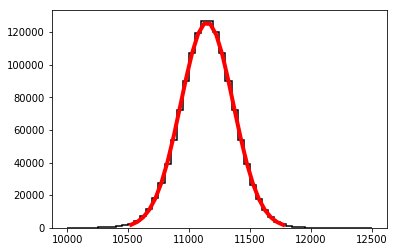

In [268]:
fc = fit_energy(Ec, nbins=50, range=(10000, 12500))
plot_fit_energy(fc)
print_fit_energy(fc)

### Time correction

(10000, 12500)

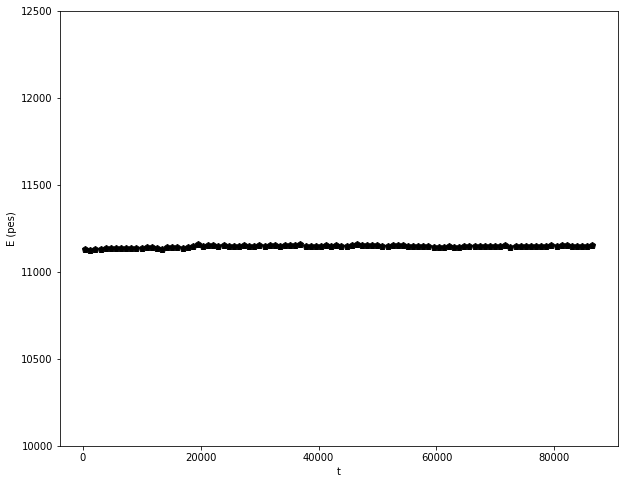

In [270]:
T   =(kge.T - kge.T.min()) 
t, e, eu = fitf.profileX(T, Ec, 100)
erange =(10000, 12500)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
plt.errorbar(t, e, eu, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E (pes)')
plt.ylim(erange)

In [271]:
e_mu    = np.nanmean(Ec)
print(e_mu)
e_std   = np.nanstd (Ec)
print(e_std)

11147.485115771047
217.70108241235508


In [272]:
ET_correction = corrf.Correction((t,), e, eu,
                                 norm_strategy =  "const",
                                 norm_opts     = {"value": e_mu})
Ek  = Ec * ET_correction(T).value

(10000, 12500)

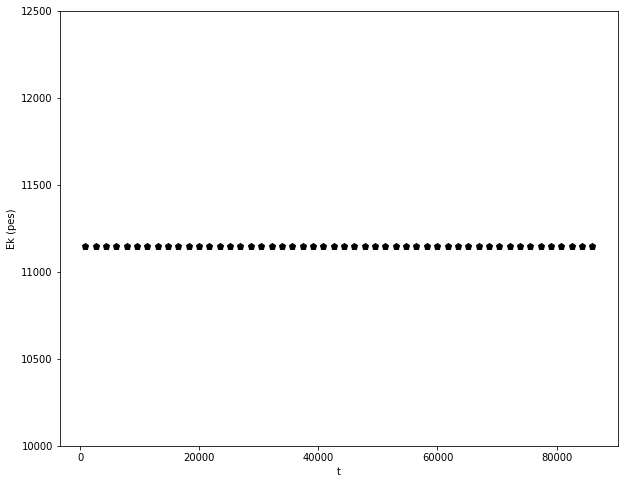

In [273]:
tc, ec, euc = fitf.profileX(T, Ek, 50)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
plt.errorbar(tc, ec, euc, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('Ek (pes)')
plt.ylim(erange)

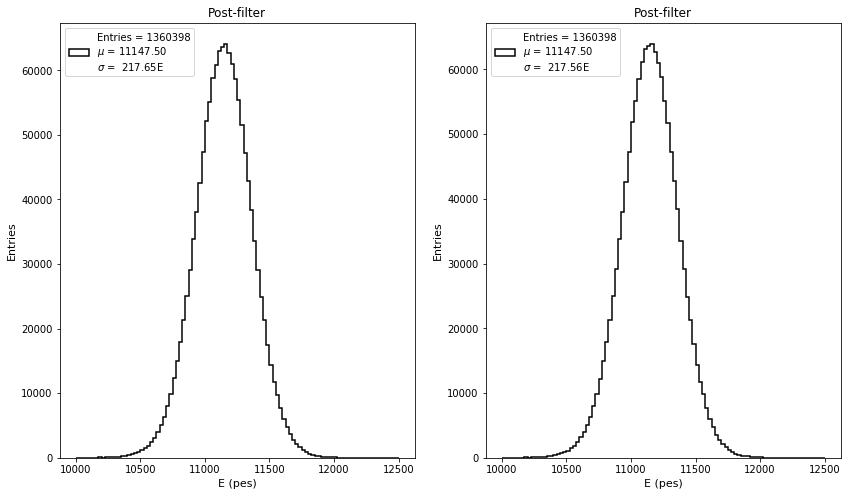

In [275]:
fig = plt.figure(figsize=(14,8))
ax      = fig.add_subplot(1, 2, 1)

(_)     = h1(Ec,  bins = 100, range =(10000,12500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')
ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(Ek,  bins = 100, range =(10000,12500), stats=True, lbl = 'E')
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')

  Fit was valid = True
 Emu       = 11148.4982946691 +-0.18709751676148115 
 E sigma   = 214.93461012787662 +-0.1423764950123274 
 chi2    = 4.965514698937917 
 sigma E/E (FWHM)     (%) =4.530622156008518
 sigma E/E (FWHM) Qbb (%) =0.5851387149043142 


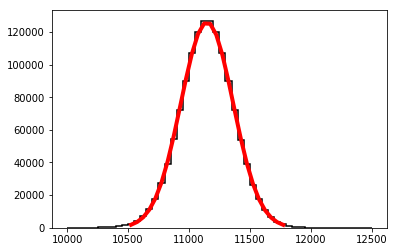

In [277]:
fc = fit_energy(Ek, nbins=50, range=(10000, 12500))
plot_fit_energy(fc)
print_fit_energy(fc)

### As a function of R and Z

In [309]:
Ri = (100,150,180)
Zi = (100,200,350, 500)

 fit failed for seed  = GaussPar(mu=Measurement(value=11149.703204266581, uncertainty=0.480734884326043), std=Measurement(value=190.5954676157001, uncertainty=0.339931977966476), amp=Measurement(value=32901.17129837461, uncertainty=0.852083107422011)), due to RunTimeWarning, retry fit 


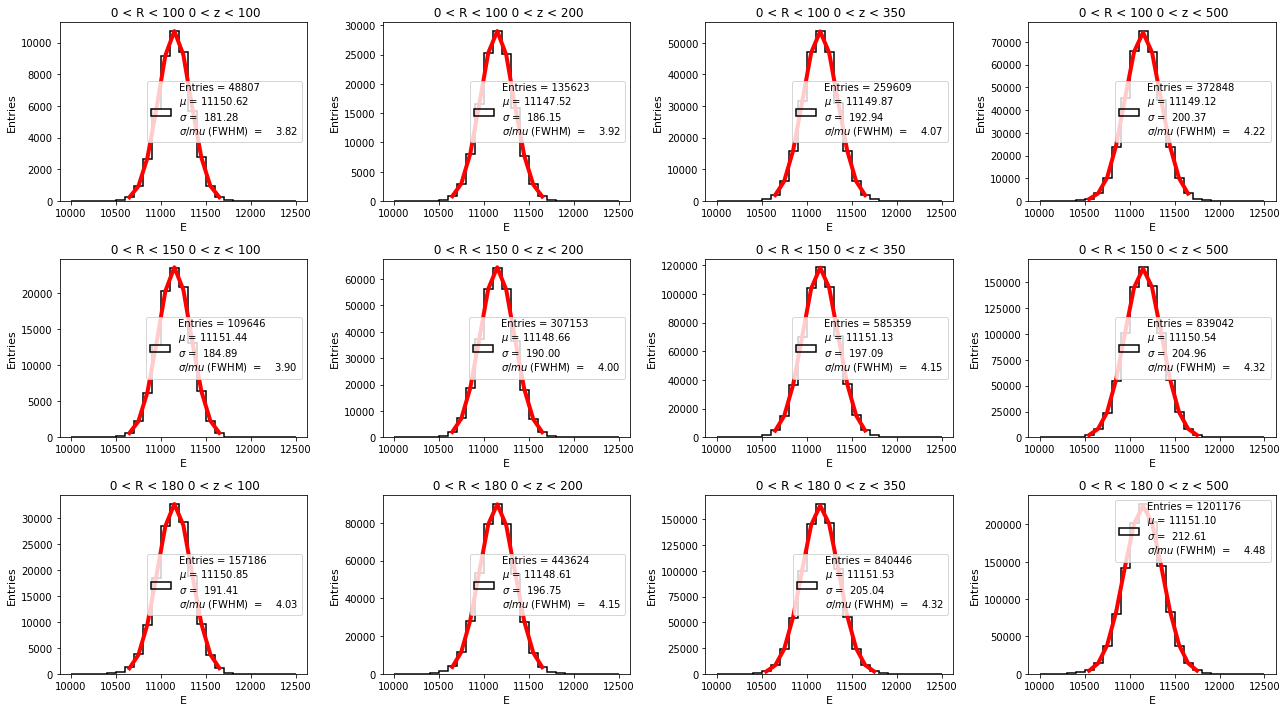

In [340]:
FC, FCE = resolution_r_z(Ri, Zi, kge.R, kge.Z, Ek,
                    enbins = 25,
                    erange = (10e+3, 12500),
                    fdraw  = True,
                    fprint = False,
                    figsize = (18,10))                                

In [324]:
FC

,0,1,2
0,3.820556,3.896331,4.033829
1,3.924228,4.004896,4.147204
2,4.066544,4.153541,4.320927
3,4.223359,4.319652,4.480591


In [341]:
FCE

,0,1,2
0,0.013139,0.009035,0.007981
1,0.008171,0.005609,0.004958
2,0.006271,0.004322,0.003554
3,0.005362,0.003542,0.003132


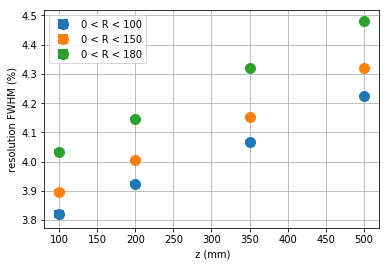

In [342]:
plot_resolution_r_z(Ri, Zi, FC, FCE)

### Is it possible to reduce the dependence in Z with time-dependent fits?

### Using single runs to produce maps do not yield worse results that trying to produce larger statistics maps. Profiles are in fact better. 

### Control better number of events in radial sectors